In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Color quantization using K-means

In [2]:
def plot_source_quantization(source_image, quantization_image):
    fig, ax = plt.subplots(1, 2, figsize=(10,7))
    fig.tight_layout()
    ax[0].imshow(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Imagem de entrada')
    ax[1].imshow(quantization_image)
    ax[1].set_title('Após a quantização')

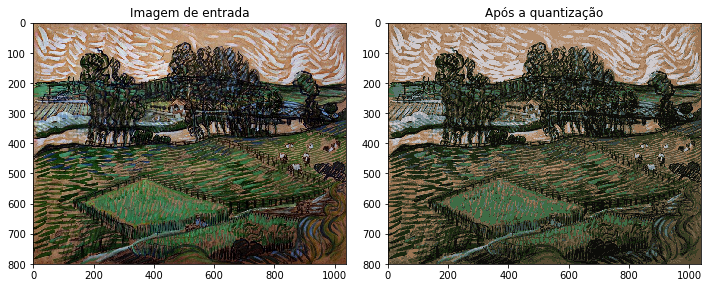

In [3]:
# https://docs.opencv.org/3.1.0/d1/d5c/tutorial_py_kmeans_opencv.html

filename = 'landscape-with-bridge-across-the-oise-1890.jpg'
img = cv2.imread('data/' + filename, cv2.COLOR_BGR2RGB)
Z = img.reshape((-1, 3))
Z = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 16
ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))
res2 = cv2.cvtColor(res2, cv2.COLOR_BGR2RGB)

plot_source_quantization(img, res2)

## Cluster colors

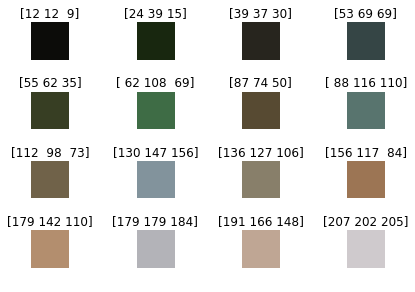

In [4]:
x, y = 4, 4 # size of color grid

color_clusters = np.unique(res2.reshape(-1, img.shape[2]), axis=0)
fig, ax = plt.subplots(x, y)
fig.tight_layout()

for i in range(x):
    for j in range(y):
        img_ij = np.full((2, 2, 3), color_clusters[i * y + j])
        
        ax[i, j].axis('off')
        ax[i, j].set_title(color_clusters[i * y + j])
        ax[i, j].imshow(img_ij)

## Binary image for each color in clusters

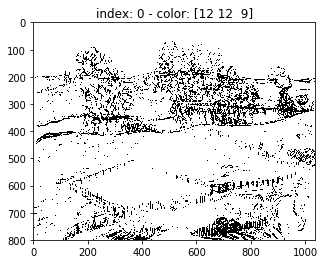

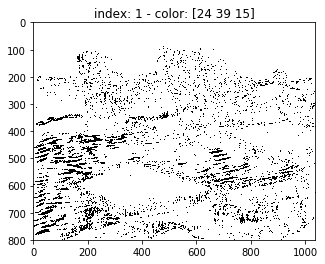

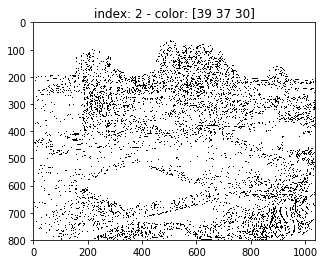

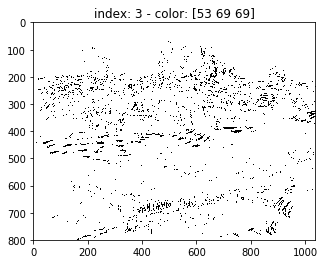

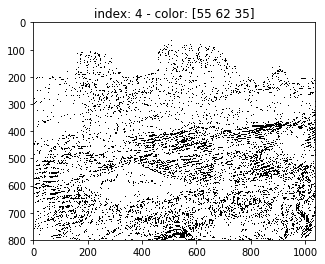

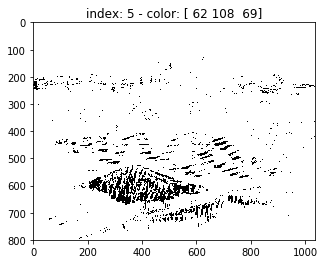

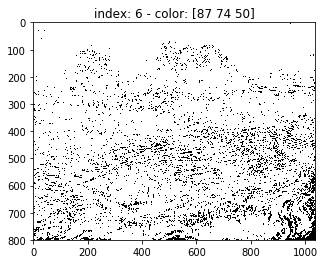

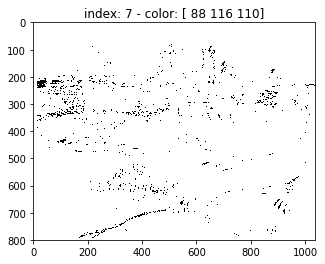

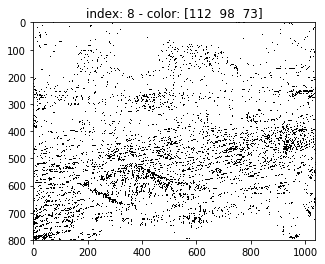

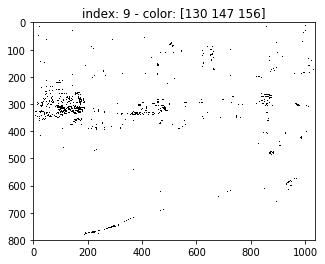

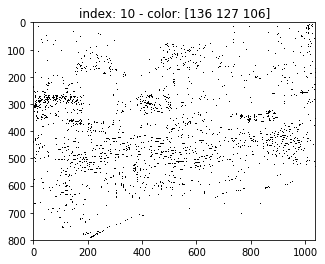

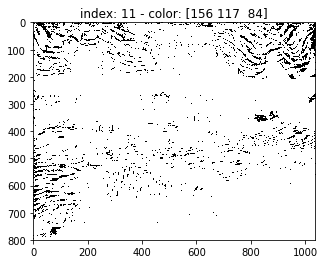

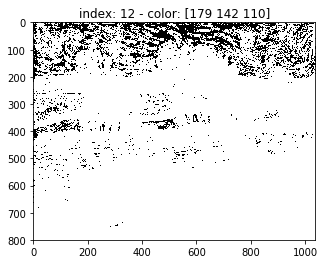

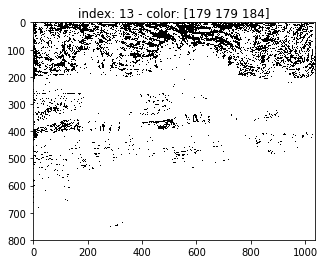

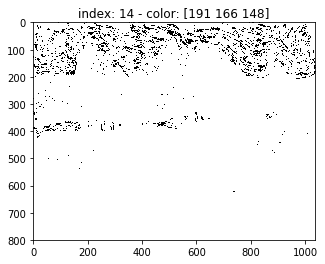

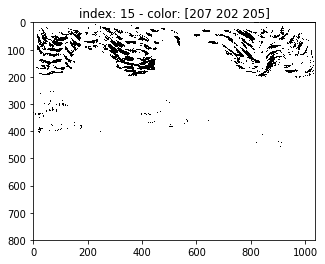

In [5]:
i = 0
binary_images = []

for c in color_clusters:
    ans = np.where(res2 == c, 0, 255)
    ans = ans[:,:,0] # just one channel
    ans = np.uint8(ans / 255) # [0, 1] values
    binary_images.append(ans)
    plt.imshow(ans, 'gray')
#     plt.imsave('binary-{}'.format(i), ans, cmap=plt.cm.gray)
    plt.title('index: {} - color: {}'.format(i, c))
    plt.show()
    i = i + 1

## Binary morphology (Closing operation)

In [6]:
def apply_closing(binary_image, kernel_size=(3, 3)):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    ans = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel);
    
    return ans

In [7]:
def plot_closing(binary_image, closing_image):
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    fig.tight_layout()
    ax[0].imshow(binary_image, 'gray')
    ax[0].set_title('before closing')
    ax[1].imshow(closing_image, 'gray')
    ax[1].set_title('after closing')

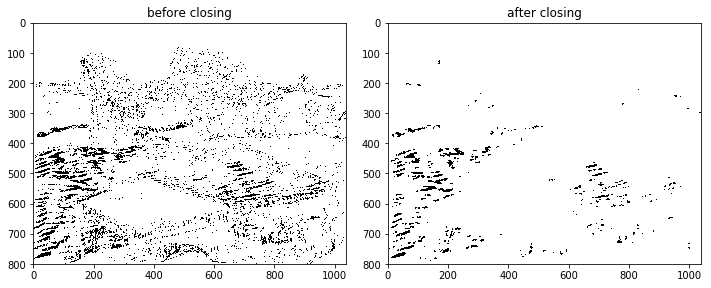

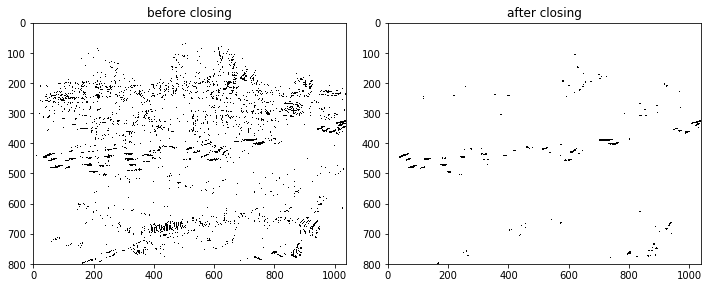

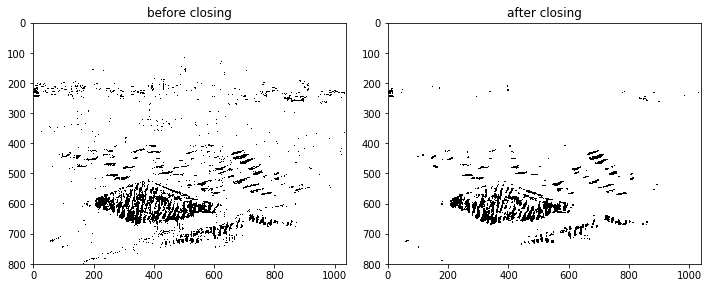

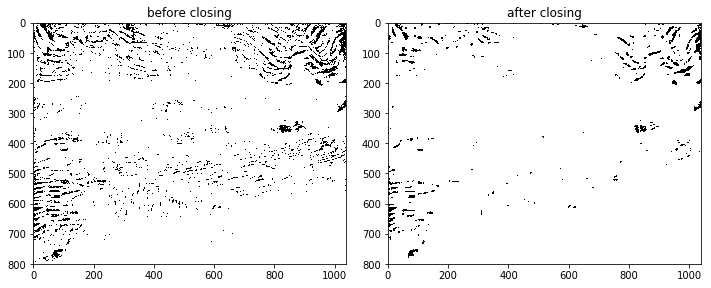

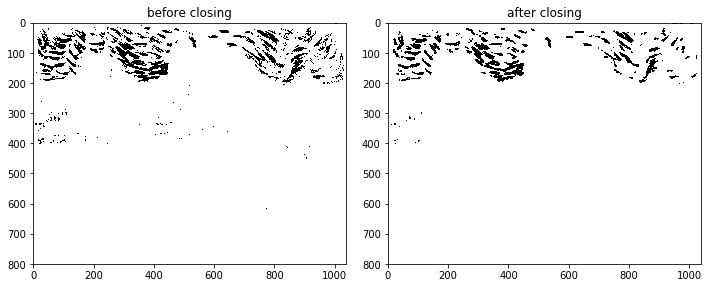

In [33]:
clusters_idxs = [1, 3, 5, 11, 15]
closing_images = []

for i in clusters_idxs:
    closing_img = apply_closing(binary_images[i], kernel_size=(4, 4))
    closing_images.append(closing_img)
    plot_closing(binary_images[i], closing_img)

## Thinning

In [34]:
def apply_thinning(img, niter=8, verbose=False):
    
    k = np.array([[[-1,-1,-1],[0,1,0],[1,1,1]], # kernels do slide 45
                  [[0,-1,-1],[1,1,-1],[1,1,0]], # -1 background, 1 foreground, 0 ignorado.
                  [[1,0,-1],[1,1,-1],[1,0,-1]],
                  [[1,1,0],[1,1,-1],[0,-1,-1]],
                  [[1,1,1],[0,1,0],[-1,-1,-1]],
                  [[0,1,1],[-1,1,1],[-1,-1,0]],
                  [[-1,0,1],[-1,1,1],[-1,0,1]],
                  [[-1,-1,0],[-1,1,1],[0,1,1]]])        
    
    for i in range(niter):
        m = cv2.morphologyEx(img, cv2.MORPH_HITMISS, k[i % 8])
        img = img * (1 - m) # thinning = img inter (complemento do hit-and-miss)
        if verbose:
            plt.imshow(k[i % 8],'gray'); plt.show()
            plt.imshow(img,'gray'); plt.show()
    
    return img

In [35]:
def plot_thinning(binary_image, thinning_image):
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    fig.tight_layout()
    ax[0].imshow(binary_image, 'gray')
    ax[0].set_title('before thinning')
    ax[1].imshow(thinning_image, 'gray')
    ax[1].set_title('after thinning')

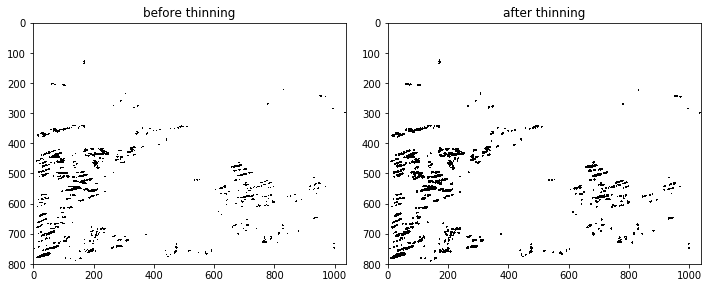

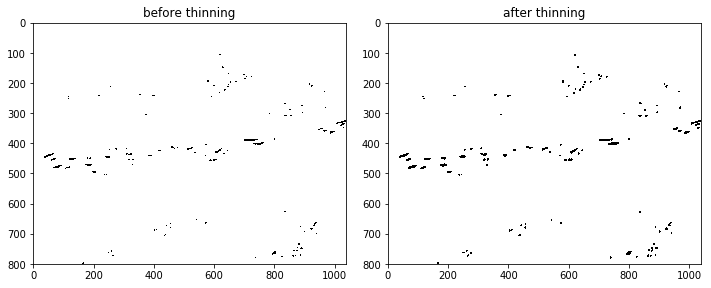

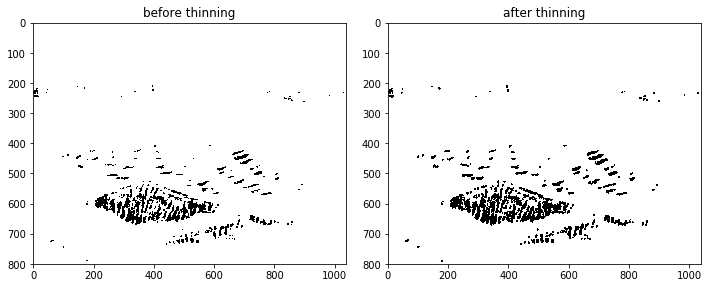

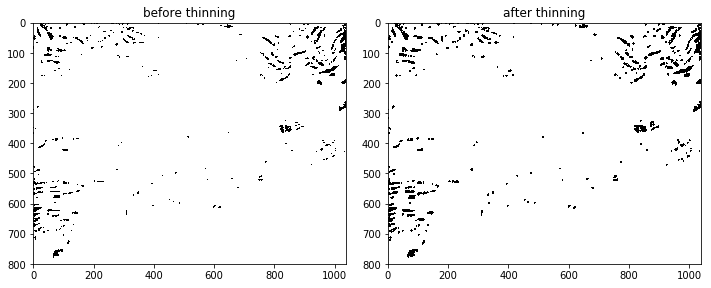

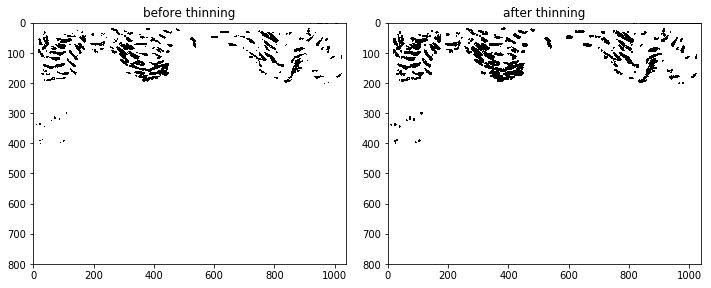

In [36]:
thinning_images = []

for img in closing_images:
    thinning_img = apply_thinning(img, niter=10)
    thinning_images.append(thinning_img)
    plot_thinning(img, thinning_img)

In [37]:
def back2quantization(thinning_img, quantization_image, inverse=False):
    img_rgb = cv2.cvtColor(thinning_img, cv2.COLOR_GRAY2RGB)
    img_rgb = np.uint8(img_rgb * 255)
    if inverse:
        ans = np.where(img_rgb == (255, 255, 255), (255, 255, 255), quantization_image)
    else: 
        ans = np.where(img_rgb == (255, 255, 255), (0, 0, 0), quantization_image)
    return ans

In [38]:
def plot_thinning_and_quantization(thinning, quantization):
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    fig.tight_layout()
    ax[0].imshow(thinning, 'gray')
#     ax[0].set_title('binary image')
    ax[0].set_title('Imagem binária')
    ax[1].imshow(quantization, 'gray')
#     ax[1].set_title('colored with cluster color')
    ax[1].set_title('Imagem colorida com a cor do centroide')

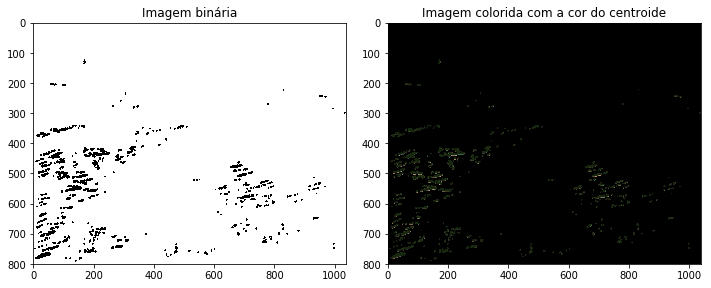

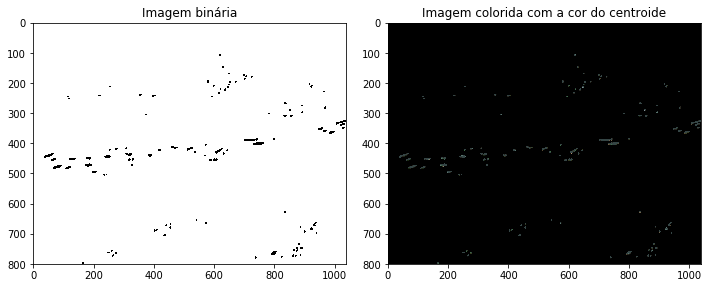

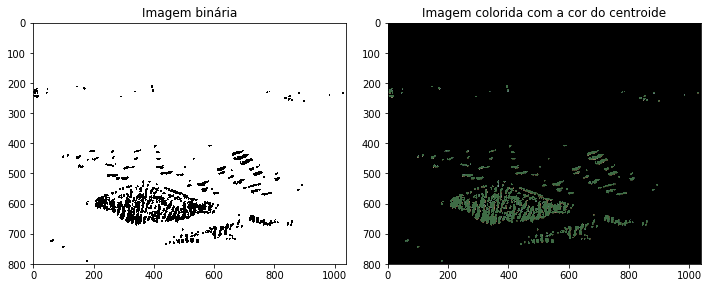

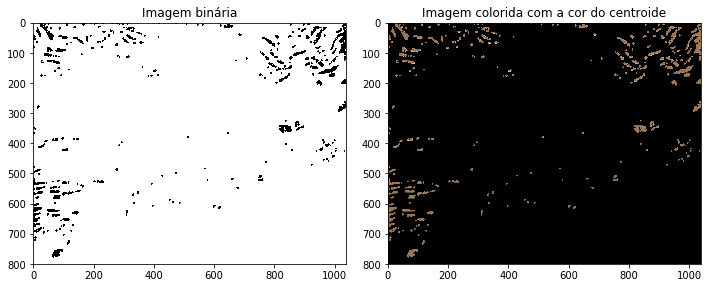

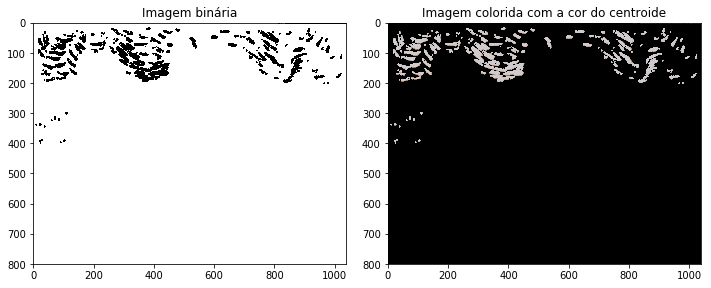

In [39]:
final_ans = np.zeros_like(res2)

for img in thinning_images:
    aux_img = back2quantization(img, res2)
    final_ans = final_ans + aux_img
    plot_thinning_and_quantization(img, aux_img)

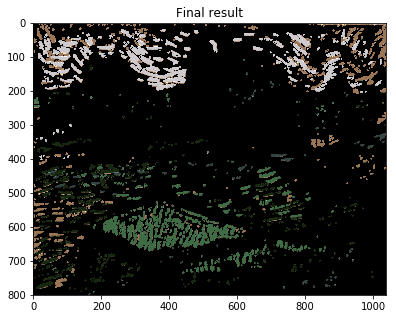

In [40]:
final_ans = final_ans.clip(0, 255)
final_ans = final_ans.astype('uint8')
plt.figure(figsize=(10, 5))
plt.title('Final result')
plt.imshow(final_ans)
plt.show()

## Save final result image

In [16]:
final_ans = cv2.cvtColor(final_ans, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_ex/louco2' + filename, final_ans)